In [ ]:
!pip install transformers xgboost
!pip install openpyxl
import numpy as np
import pandas as pd
import nltk
import os
import torch

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier
from transformers import BertModel, BertTokenizer


# NLTK setup
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Global parameters
patient_subset = 1   # 1 - All patients, 2 - Patients with Notes, 3 - Patients without Notes
feature_subset = 1   # 1 - Demo, 2 - Demo + Tabular, 3 - Demo + Tabular + Notes
feat_sel = 1         # 1 = Feature selection on (RandomForest), 0 = off
test_split_ratio = 0.2
seed = 23
vectorize_text = 2   # 1 - TF-IDF, 2 - BERT
file_path = 'new_final_df.xlsx'
output_csv = 'training_log.csv'
demographic_features = ['visit_number', 'referral_date', 'day_readmit',	'age',
                        'sex_Male', 'Hispanic', 'AfricanAmerican', 'White',
                       'Additional_race', 'language_English', 'language_Spanish',
                      'language_Other', 'hypertension']

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
min_max_scaler = MinMaxScaler()

for patient_subset in range(1,4):
    for feature_subset in range(3,4):
        for engaged in range(0,2):
          for seed in range(0,50,10):
            # Load data
            suhi_df = pd.read_excel(file_path)
            suhi_df = suhi_df[suhi_df['engaged']==engaged]

        # for feat_sel in range(0,2):
        # for seed in range(0,50,14):

            if patient_subset == 3 and feature_subset == 3:
                continue



            ###############################################################################
            # Utility function: Append a single row (dict) to CSV, with an auto-incremented Run ID
            ###############################################################################
            def append_results_to_csv(results_dict, csv_file):
                # Check if the file exists
                if os.path.exists(csv_file):
                    df_existing = pd.read_csv(csv_file)
                    if 'Run ID' in df_existing.columns:
                        max_run_id = df_existing['Run ID'].max()
                    else:
                        max_run_id = 0
                    new_run_id = max_run_id + 1
                    results_dict['Run ID'] = new_run_id

                    # Append the new row
                    df_new = pd.DataFrame([results_dict])
                    df_combined = pd.concat([df_existing, df_new], ignore_index=True)
                    df_combined.to_csv(csv_file, index=False)
                else:
                    # If no file, create a new DataFrame
                    results_dict['Run ID'] = 1
                    df_new = pd.DataFrame([results_dict])
                    df_new.to_csv(csv_file, index=False)

            ###############################################################################
            # Preprocessing function
            ###############################################################################
            def preprocess(suhi_df):
                # Drop columns
                suhi_df.drop(columns=['record_id', 'new_patient'], inplace=True, errors='ignore')
                # Remove rows with NaN in day_readmit
                suhi_df.dropna(subset=['day_readmit'], inplace=True)
                # Convert day_readmit == 2 to 0
                suhi_df.loc[suhi_df['day_readmit'] == 2, 'day_readmit'] = 0
                # Convert day_readmit to int
                suhi_df['day_readmit'] = suhi_df['day_readmit'].astype(int)
                # Scale age
                suhi_df['age'] = min_max_scaler.fit_transform(suhi_df[['age']])

                # Combine note columns
                note_cols = suhi_df.columns[suhi_df.columns.str.contains('notes_contact')]
                combined_notes = suhi_df[note_cols].apply(
                    lambda x: '. '.join([str(note).lower() for note in x.dropna()]),
                    axis=1
                )
                suhi_df['combined_notes'] = combined_notes
                return suhi_df

            ###############################################################################
            # Main Script Execution
            ###############################################################################

            # Preprocess
            suhi_df = preprocess(suhi_df)

            # If we only want patients with notes
            if patient_subset == 2:
                suhi_df['combined_notes'] = suhi_df['combined_notes'].replace('', np.nan)
                suhi_df.dropna(subset=['combined_notes'], inplace=True)

            # If we only want patients without notes
            if patient_subset == 3:
                suhi_df['combined_notes'] = suhi_df['combined_notes'].replace('', np.nan)
                suhi_df = suhi_df[suhi_df['combined_notes'].isna()]
                # suhi_df['combined_notes'].fillna('', inplace=True)

            # If feature_subset == 1 -> only Demographic (first 13 columns)
            if feature_subset == 1:
                # suhi_df = suhi_df[suhi_df.columns[:13]]
                suhi_df = suhi_df[demographic_features]

            # If we include text features and vectorize them using TF-IDF
            if feature_subset == 3 and vectorize_text == 1:
                tfidf_vectorizer = TfidfVectorizer(
                    min_df=20,
                    max_df=0.7,
                    stop_words='english',
                    token_pattern=r'[a-zA-Z]{2,}'
                )
                text_embeddings = tfidf_vectorizer.fit_transform(suhi_df['combined_notes'])

            # If we include text features and vectorize them using BERT embeddings
            if feature_subset == 3 and vectorize_text == 2:
                # Load pre-trained BERT model
                model = BertModel.from_pretrained('bert-base-uncased')
                tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
                model.eval()
                device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                model.to(device)


                # Tokenize and encode the text
                text_embeddings = tokenizer(suhi_df['combined_notes'].tolist(), padding=True, truncation=True, return_tensors='pt')
                text_embeddings = text_embeddings.to(device)
                text_embeddings = model(**text_embeddings)
                text_embeddings = text_embeddings.pooler_output


            # Drop textual/object columns (except for combining them if we do text vectorizing)
            text_columns = [col for col in suhi_df.columns if suhi_df[col].dtype == 'object']
            suhi_df.drop(columns=text_columns, inplace=True, errors='ignore')

            # Drop date columns
            date_columns = [col for col in suhi_df.columns if suhi_df[col].dtype == 'datetime64[ns]']
            suhi_df.drop(columns=date_columns, inplace=True, errors='ignore')

            # Drop columns that contain 'nores'
            nores_columns = [col for col in suhi_df.columns if 'nores' in col]
            suhi_df.drop(columns=nores_columns, inplace=True, errors='ignore')

            # If we have vectorized text, merge them in
            if feature_subset == 3:
                combined_notes_vectorized_df = pd.DataFrame(text_embeddings.toarray())
                combined_notes_vectorized_df.columns = tfidf_vectorizer.get_feature_names_out()

                suhi_df.reset_index(drop=True, inplace=True)
                suhi_w_vectors_df = pd.concat([suhi_df, combined_notes_vectorized_df], axis=1)
            else:
                suhi_w_vectors_df = suhi_df

            # Fill NaN with 0
            suhi_w_vectors_df.fillna(0, inplace=True)
            print(100*'-')
            print(patient_subset, feature_subset)
            print(suhi_w_vectors_df.shape)
            print(suhi_w_vectors_df.head)
            # Split data
            X = suhi_w_vectors_df.drop('day_readmit', axis=1)
            y = suhi_w_vectors_df['day_readmit']

            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_split_ratio, random_state=seed
            )

            ###############################################################################
            # We'll collect all our results in one dictionary, final_results,
            # so we only write one row per script run.
            ###############################################################################
            final_results = {}
            final_results["Patient Subset"] = patient_subset
            final_results["Feature Subset"] = feature_subset
            # final_results["Feature Selection"] = bool(feat_sel)
            final_results["Engaged"] = engaged
            # final_results["Random Seed"] = seed
            # final_results["File Name"] = file_path

            top_25_features = []
            top_25_percent_features_str = ""

            ###############################################################################
            # Feature Selection (RandomForest) step, if enabled
            ###############################################################################
            if feat_sel == 1:
                fs_rf = RandomForestClassifier(random_state=seed)
                param_grid_rf = {
                    'n_estimators': [50, 100, 200],
                    'max_depth': [10, 20],
                    'min_samples_split': [5, 20],
                    'min_samples_leaf': [1, 5]
                }
                cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

                grid_search = GridSearchCV(
                    estimator=fs_rf,
                    param_grid=param_grid_rf,
                    cv=cv,
                    scoring='roc_auc',
                    refit=True,
                    return_train_score=True,
                    n_jobs=-1,
                    verbose=1
                )

                grid_search.fit(X_train, y_train)

                # Best/Worst model indices in the results
                best_model_idx = grid_search.cv_results_['rank_test_score'].argmin()
                worst_model_idx = grid_search.cv_results_['rank_test_score'].argmax()

                # Retrieve relevant metrics
                # fs_best_mean_train_score = round(grid_search.cv_results_['mean_train_score'][best_model_idx], 4)
                # fs_best_std_train_score = round(grid_search.cv_results_['std_train_score'][best_model_idx], 4)
                fs_best_mean_test_score = round(grid_search.cv_results_['mean_test_score'][best_model_idx], 4)
                fs_best_std_test_score = round(grid_search.cv_results_['std_test_score'][best_model_idx], 4)

                # fs_worst_mean_train_score = round(grid_search.cv_results_['mean_train_score'][worst_model_idx], 4)
                # fs_worst_std_train_score = round(grid_search.cv_results_['std_train_score'][worst_model_idx], 4)
                # fs_worst_mean_test_score = round(grid_search.cv_results_['mean_test_score'][worst_model_idx], 4)
                # fs_worst_std_test_score = round(grid_search.cv_results_['std_test_score'][worst_model_idx], 4)

                # Best estimator
                best_rf = grid_search.best_estimator_
                best_params_fs = best_rf.get_params()

                # Evaluate on test set
                y_pred = best_rf.predict(X_test)
                y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

                fs_test_accuracy = round(accuracy_score(y_test, y_pred), 4)
                fs_test_roc_auc = round(roc_auc_score(y_test, y_pred_proba), 4)
                fs_clf_report = classification_report(y_test, y_pred)

                if feature_subset != 1:
                    # Feature Importances
                    feature_importances = best_rf.feature_importances_
                    sorted_idx = np.argsort(feature_importances)[::-1]
                    important_features = [X_train.columns[i] for i in sorted_idx]

                    top_25_percent = int(0.25 * len(feature_importances))
                    top_25_features = important_features[:top_25_percent]
                    top_25_percent_features_str = ", ".join(top_25_features)

                    # Filter X_train, X_test to only top 25% features
                    X_train = X_train[top_25_features]
                    X_test = X_test[top_25_features]

                # Store all in final_results
                # final_results["FS_Best_Mean_Train_Score"] = fs_best_mean_train_score
                # final_results["FS_Best_Std_Train_Score"] = fs_best_std_train_score
                final_results["FS_CV_Test"] = fs_best_mean_test_score
                # final_results["FS_Best_Std_Test_Score"] = fs_best_std_test_score

                # final_results["FS_Worst_Mean_Train_Score"] = fs_worst_mean_train_score
                # final_results["FS_Worst_Std_Train_Score"] = fs_worst_std_train_score
                # final_results["FS_Worst_Mean_Test_Score"] = fs_worst_mean_test_score
                # final_results["FS_Worst_Std_Test_Score"] = fs_worst_std_test_score

                # final_results["FS_Best_Params"] = str(best_params_fs)
                # final_results["FS_Test_Accuracy"] = fs_test_accuracy
                final_results["FS_Test"] = fs_test_roc_auc
                # final_results["FS_Classification_Report"] = fs_clf_report
                # final_results["FS_Top_25_Features"] = top_25_percent_features_str
            else:
                # If no feature selection, store placeholders or empty strings
                final_results["FS_Best_Mean_Train_Score"] = ""
                final_results["FS_Best_Std_Train_Score"] = ""
                final_results["FS_Best_Mean_Test_Score"] = ""
                final_results["FS_Best_Std_Test_Score"] = ""

                final_results["FS_Worst_Mean_Train_Score"] = ""
                final_results["FS_Worst_Std_Train_Score"] = ""
                final_results["FS_Worst_Mean_Test_Score"] = ""
                final_results["FS_Worst_Std_Test_Score"] = ""

                final_results["FS_Best_Params"] = ""
                final_results["FS_Test_Accuracy"] = ""
                final_results["FS_Test_ROC_AUC"] = ""
                final_results["FS_Classification_Report"] = ""
                final_results["FS_Top_25_Features"] = ""

            ###############################################################################
            # Define our classifiers and grids
            ###############################################################################
            classifiers_and_grids = {
                "RandomForestClassifier": (
                    RandomForestClassifier(random_state=seed),
                    {
                        "n_estimators": [100, 200],
                        "max_depth": [10, 20],
                        "min_samples_split": [2, 5]
                    }
                ),
                "AdaBoostClassifier": (
                    AdaBoostClassifier(random_state=seed),
                    {
                        "n_estimators": [50, 100],
                        "learning_rate": [0.1, 0.5, 1.0]
                    }
                ),
                "XGBClassifier": (
                    XGBClassifier(random_state=seed, eval_metric='auc'),
                    {
                        "n_estimators": [50, 100],
                        "max_depth": [3, 5],
                        "learning_rate": [0.01, 0.1]
                    }
                ),
                # "VotingClassifier": (
                #     VotingClassifier(
                #         estimators=[('rf', RandomForestClassifier(random_state=seed)),
                #                     ('xgb', XGBClassifier(random_state=seed, eval_metric='auc')),
                #                     ('ada', AdaBoostClassifier(random_state=seed))],
                #         voting='soft'
                #     ),
                #     {
                #     'rf__n_estimators': [100, 200],
                #     'rf__max_depth': [10, 20],
                #     'xgb__learning_rate': [0.1, 0.5, 1.0],
                #     'xgb__n_estimators': [100, 200],
                #     'xgb__max_depth': [10, 20],
                #     'ada__n_estimators': [100, 200],
                #     'ada__learning_rate': [0.1, 0.5, 1.0]
                # }
                # )
            }

            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

            ###############################################################################
            # Train each classifier, store best & worst metrics in final_results
            ###############################################################################
            for clf_name, (clf, param_grid) in classifiers_and_grids.items():
                grid_search = GridSearchCV(
                    estimator=clf,
                    param_grid=param_grid,
                    scoring="roc_auc",
                    cv=cv,
                    refit=True,
                    return_train_score=True,
                    n_jobs=-1,
                    verbose=1
                )

                grid_search.fit(X_train, y_train)

                # Indices of best and worst models
                best_model_idx = grid_search.cv_results_['rank_test_score'].argmin()
                worst_model_idx = grid_search.cv_results_['rank_test_score'].argmax()

                # Best model metrics
                best_mean_train_score = round(grid_search.cv_results_['mean_train_score'][best_model_idx], 4)
                best_std_train_score = round(grid_search.cv_results_['std_train_score'][best_model_idx], 4)
                best_mean_test_score = round(grid_search.cv_results_['mean_test_score'][best_model_idx], 4)
                best_std_test_score = round(grid_search.cv_results_['std_test_score'][best_model_idx], 4)

                # Worst model metrics
                worst_mean_train_score = round(grid_search.cv_results_['mean_train_score'][worst_model_idx], 4)
                worst_std_train_score = round(grid_search.cv_results_['std_train_score'][worst_model_idx], 4)
                worst_mean_test_score = round(grid_search.cv_results_['mean_test_score'][worst_model_idx], 4)
                worst_std_test_score = round(grid_search.cv_results_['std_test_score'][worst_model_idx], 4)

                # Best estimator
                best_model = grid_search.best_estimator_
                best_params = best_model.get_params()

                # Predict on test set
                y_pred = best_model.predict(X_test)
                y_pred_proba = best_model.predict_proba(X_test)[:, 1]

                test_accuracy = round(accuracy_score(y_test, y_pred), 4)
                test_roc_auc = round(roc_auc_score(y_test, y_pred_proba), 4)
                clf_report = classification_report(y_test, y_pred)

                # Store results for this classifier
                # We'll prefix the columns with the classifier name to keep them unique
                # final_results[f"{clf_name}_Best_Mean_Train_Score"] = best_mean_train_score
                # final_results[f"{clf_name}_Best_Std_Train_Score"] = best_std_train_score
                final_results[f"{clf_name}_CV_Test"] = best_mean_test_score
                # final_results[f"{clf_name}_Best_Std_Test_Score"] = best_std_test_score

                # final_results[f"{clf_name}_Worst_Mean_Train_Score"] = worst_mean_train_score
                # final_results[f"{clf_name}_Worst_Std_Train_Score"] = worst_std_train_score
                # final_results[f"{clf_name}_Worst_Mean_Test_Score"] = worst_mean_test_score
                # final_results[f"{clf_name}_Worst_Std_Test_Score"] = worst_std_test_score

                # final_results[f"{clf_name}_Best_Model_Params"] = str(best_params)
                # final_results[f"{clf_name}_Test_Accuracy"] = test_accuracy
                final_results[f"{clf_name}_Test"] = test_roc_auc
                # final_results[f"{clf_name}_Classification_Report"] = clf_report

            ###############################################################################
            # Append exactly ONE row for this entire run
            ###############################################################################
            append_results_to_csv(final_results, output_csv)
            print(f"\nDone! Logged results to {output_csv} as a single row.\n")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 4.3 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Import classifier models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Other required libraries
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sentence_transformers import SentenceTransformer, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import numpy as np
import pandas as pd
# from scipy.sparse import csr_matrix
from sklearn.preprocessing import MinMaxScaler
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
min_max_scaler = MinMaxScaler()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
suhi_df = pd.read_excel('final_df.xlsx')

In [ ]:
# Combining notes
combined_notes = suhi_df[suhi_df.columns[suhi_df.columns.str.contains('notes_contact')]].apply(
    lambda x: '. '.join([note for note in x.dropna().astype(str).str.lower()]),
    axis=1
)

In [ ]:
# Demographic
suhi_df = suhi_df[suhi_df.columns[:14]]

In [ ]:
# When notes are used
suhi_df['combined_notes'] = combined_notes

In [ ]:
# suhi_df['combined_notes'] = suhi_df[suhi_df.columns[suhi_df.columns.str.contains('notes_contact')]].apply(
#     lambda x: '. '.join([note for note in x.dropna().astype(str).str.lower()]),
#     axis=1
# )

In [ ]:
# Pre-processing
suhi_df.drop(columns = ['record_id', 'new_patient'], inplace = True)
suhi_df.dropna(subset=['day_readmit'] ,inplace = True)
suhi_df.loc[suhi_df['day_readmit'] == 2, 'day_readmit'] = 0
suhi_df['day_readmit'] = suhi_df['day_readmit'].astype(int)
suhi_df['age'] = min_max_scaler.fit_transform(suhi_df[['age']])

In [ ]:
# Patient with notes
suhi_df['combined_notes'] = suhi_df['combined_notes'].replace('', np.nan)
suhi_df.dropna(subset=['combined_notes'] ,inplace = True)

In [ ]:
# Patients without notes
suhi_df['combined_notes'] = suhi_df['combined_notes'].replace('', np.nan)
suhi_wo_notes_df = suhi_df[suhi_df['combined_notes'].isna()]

In [ ]:
# Vectorization
tfidf_vectorizer = TfidfVectorizer(min_df=20, max_df=0.7, stop_words='english', token_pattern=r'[a-zA-Z]{2,}')
text_embeddings = tfidf_vectorizer.fit_transform(suhi_df['combined_notes'])

In [ ]:
# Dropping Text, Date columns
text_columns = []
for col in suhi_df.columns:
    if suhi_df[col].dtype == 'object':
        text_columns.append(col)
suhi_df.drop(columns = text_columns, inplace = True)

date_columns = []
for col in suhi_df.columns:
    if suhi_df[col].dtype == 'datetime64[ns]':
        date_columns.append(col)
suhi_df.drop(columns = date_columns, inplace = True)

nores_columns = []
for col in suhi_df.columns:
    if 'nores' in col:
        nores_columns.append(col)
suhi_df.drop(columns = nores_columns, inplace = True)


In [ ]:
# Dropping Text, Date columns for patients without notes subset
text_columns = []
for col in suhi_wo_notes_df.columns:
    if suhi_wo_notes_df[col].dtype == 'object':
        text_columns.append(col)
suhi_wo_notes_df.drop(columns = text_columns, inplace = True)

date_columns = []
for col in suhi_wo_notes_df.columns:
    if suhi_wo_notes_df[col].dtype == 'datetime64[ns]':
        date_columns.append(col)
suhi_wo_notes_df.drop(columns = date_columns, inplace = True)

nores_columns = []
for col in suhi_wo_notes_df.columns:
    if 'nores' in col:
        nores_columns.append(col)
suhi_wo_notes_df.drop(columns = nores_columns, inplace = True)


<ipython-input-66-b41b0727c7bf>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suhi_wo_notes_df.drop(columns = text_columns, inplace = True)
<ipython-input-66-b41b0727c7bf>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suhi_wo_notes_df.drop(columns = date_columns, inplace = True)
<ipython-input-66-b41b0727c7bf>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suhi_wo_notes_df.drop(columns = nores_columns, inplace = True)


In [ ]:
suhi_wo_notes_df.shape

(1050, 58)

In [ ]:
suhi_wo_notes_df.columns[:100]

Index(['visit_number', 'day_readmit', 'age', 'sex_Male', 'Hispanic',
       'AfricanAmerican', 'White', 'Additional_race', 'language_English',
       'language_Spanish', 'language_Other', 'hypertension',
       'public_insurance', 'private_insurance', 'unlisted_insurance',
       'uninsured', 'contactmade_yesno', 'sdoh_PCP', 'sdoh_INS',
       'sdoh_HOUSING', 'sdoh_FOOD', 'sdoh_UTIL', 'sdoh_TRANS', 'sdoh_EMPLOY',
       'sdoh_CLOTH_CHILD_PHONE', 'sdoh_DV', 'sdoh_HIV', 'sdoh_COVID',
       'sdoh_DIABETES', 'sdoh_ASTHMA', 'sdoh_BILL_FU_RX_HEALTH',
       'sdoh_EMOTIONAL', 'sdoh_SUBSTANCE_ABUSE', 'sdoh_SAFETY',
       'sdoh_HOME_EQUIP', 'sdoh_LEGAL', 'sdoh_OTHER', 'total_time_spent',
       'PCP_referrals_used', 'insurance_referrals_used',
       'housing_referrals_used', 'food_referrals_used', 'util_referrals_used',
       'trans_referrals_used', 'employ_referrals_used',
       'cloth_child_phone_referrals_used', 'dv_referrals_used',
       'hiv_referrals_used', 'covid_referrals_used', '

In [ ]:
# If vectorization is not required
suhi_w_vectors_df = suhi_df

In [ ]:
# Convert to DataFrame
combined_notes_vectorized_df = pd.DataFrame(text_embeddings.toarray())
combined_notes_vectorized_df.columns = tfidf_vectorizer.get_feature_names_out()

# Append to an existing DataFrame
suhi_df.reset_index(drop=True, inplace=True)
suhi_w_vectors_df = pd.concat([suhi_df, combined_notes_vectorized_df], axis=1)

In [ ]:
# Create a dataframe with all the values as 0's for tfidf_vectorizer.get_feature_names_out()
zero_df = pd.DataFrame(0, index=suhi_wo_notes_df.index, columns=tfidf_vectorizer.get_feature_names_out())
# Concatenate zero_df with Without notes
suhi_wo_notes_df = pd.concat([suhi_wo_notes_df, zero_df], axis=1)

In [ ]:
# Fill null values with 0
suhi_w_vectors_df.fillna(0, inplace = True)

In [ ]:
suhi_wo_notes_df.fillna(0, inplace = True)

In [ ]:
suhi_w_vectors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1471 entries, 0 to 1470
Columns: 418 entries, visit_number to yesterday
dtypes: float64(384), int64(34)
memory usage: 4.7 MB


In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    suhi_w_vectors_df.drop('day_readmit', axis=1), suhi_w_vectors_df['day_readmit'], test_size=0.2, random_state=23
)

In [ ]:
fs_rf = RandomForestClassifier(random_state=23)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [5, 20],
    'min_samples_leaf': [1, 5]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)

grid_search = GridSearchCV(
    estimator=fs_rf,
    param_grid=param_grid_rf,
    cv=cv,
    scoring='roc_auc',
    refit=True,
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Best/Worst model indices in the results
best_model_idx = grid_search.cv_results_['rank_test_score'].argmin()
worst_model_idx = grid_search.cv_results_['rank_test_score'].argmax()

# Retrieve relevant metrics
fs_best_mean_train_score = round(grid_search.cv_results_['mean_train_score'][best_model_idx], 4)
fs_best_std_train_score = round(grid_search.cv_results_['std_train_score'][best_model_idx], 4)
fs_best_mean_test_score = round(grid_search.cv_results_['mean_test_score'][best_model_idx], 4)
fs_best_std_test_score = round(grid_search.cv_results_['std_test_score'][best_model_idx], 4)

fs_worst_mean_train_score = round(grid_search.cv_results_['mean_train_score'][worst_model_idx], 4)
fs_worst_std_train_score = round(grid_search.cv_results_['std_train_score'][worst_model_idx], 4)
fs_worst_mean_test_score = round(grid_search.cv_results_['mean_test_score'][worst_model_idx], 4)
fs_worst_std_test_score = round(grid_search.cv_results_['std_test_score'][worst_model_idx], 4)

# Best estimator
best_rf = grid_search.best_estimator_
best_params_fs = best_rf.get_params()

# Evaluate on test set
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

fs_test_accuracy = round(accuracy_score(y_test, y_pred), 4)
fs_test_roc_auc = round(roc_auc_score(y_test, y_pred_proba), 4)
fs_clf_report = classification_report(y_test, y_pred)

# Feature Importances
feature_importances = best_rf.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]
important_features = [X_train.columns[i] for i in sorted_idx]

top_25_percent = int(0.25 * len(feature_importances))
top_25_features = important_features[:top_25_percent]
top_25_percent_features_str = ", ".join(top_25_features)

# Filter X_train, X_test to only top 25% features
X_train = X_train[top_25_features]
X_test = X_test[top_25_features]

# # Store all in final_results
# final_results["FS_Best_Mean_Train_Score"] = fs_best_mean_train_score
# final_results["FS_Best_Std_Train_Score"] = fs_best_std_train_score
# final_results["FS_Best_Mean_Test_Score"] = fs_best_mean_test_score
# final_results["FS_Best_Std_Test_Score"] = fs_best_std_test_score

# final_results["FS_Worst_Mean_Train_Score"] = fs_worst_mean_train_score
# final_results["FS_Worst_Std_Train_Score"] = fs_worst_std_train_score
# final_results["FS_Worst_Mean_Test_Score"] = fs_worst_mean_test_score
# final_results["FS_Worst_Std_Test_Score"] = fs_worst_std_test_score

# final_results["FS_Best_Params"] = str(best_params_fs)
# final_results["FS_Test_Accuracy"] = fs_test_accuracy
# final_results["FS_Test_ROC_AUC"] = fs_test_roc_auc
# final_results["FS_Classification_Report"] = fs_clf_report
# final_results["FS_Top_25_Features"] = top_25_percent_features_str


Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
best_rf

RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=5,
                       n_estimators=200, random_state=23)

In [ ]:
y_pred = best_rf.predict(suhi_wo_notes_df.drop('day_readmit', axis=1))
y_pred_proba = best_rf.predict_proba(suhi_wo_notes_df.drop('day_readmit', axis=1))[:, 1]

test_accuracy = round(accuracy_score(suhi_wo_notes_df['day_readmit'], y_pred), 4)
test_roc_auc = round(roc_auc_score(suhi_wo_notes_df['day_readmit'], y_pred_proba), 4)
clf_report = classification_report(suhi_wo_notes_df['day_readmit'], y_pred)
print(f"\n{best_rf} Results:")
print(clf_report)
print(test_roc_auc)


RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=5,
                       n_estimators=200, random_state=23) Results:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       672
           1       0.00      0.00      0.00       378

    accuracy                           0.64      1050
   macro avg       0.32      0.50      0.39      1050
weighted avg       0.41      0.64      0.50      1050

0.5692


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
best_clf_list = []
classifiers_and_grids = {
    "RandomForestClassifier": (
        RandomForestClassifier(random_state=23),
        {
            "n_estimators": [100, 200],
            "max_depth": [10, 20],
            "min_samples_split": [2, 5]
        }
    ),
    "AdaBoostClassifier": (
        AdaBoostClassifier(random_state=23),
        {
            "n_estimators": [50, 100],
            "learning_rate": [0.1, 0.5, 1.0]
        }
    ),
    "XGBClassifier": (
        XGBClassifier(random_state=23, eval_metric='auc'),
        {
            "n_estimators": [50, 100],
            "max_depth": [3, 5],
            "learning_rate": [0.01, 0.1]
        }
    )
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)

###############################################################################
# Train each classifier, store best & worst metrics in final_results
###############################################################################
for clf_name, (clf, param_grid) in classifiers_and_grids.items():
    grid_search = GridSearchCV(
        estimator=clf,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=cv,
        refit=True,
        return_train_score=True,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    # Indices of best and worst models
    best_model_idx = grid_search.cv_results_['rank_test_score'].argmin()
    worst_model_idx = grid_search.cv_results_['rank_test_score'].argmax()

    # Best model metrics
    best_mean_train_score = round(grid_search.cv_results_['mean_train_score'][best_model_idx], 4)
    best_std_train_score = round(grid_search.cv_results_['std_train_score'][best_model_idx], 4)
    best_mean_test_score = round(grid_search.cv_results_['mean_test_score'][best_model_idx], 4)
    best_std_test_score = round(grid_search.cv_results_['std_test_score'][best_model_idx], 4)

    # Worst model metrics
    worst_mean_train_score = round(grid_search.cv_results_['mean_train_score'][worst_model_idx], 4)
    worst_std_train_score = round(grid_search.cv_results_['std_train_score'][worst_model_idx], 4)
    worst_mean_test_score = round(grid_search.cv_results_['mean_test_score'][worst_model_idx], 4)
    worst_std_test_score = round(grid_search.cv_results_['std_test_score'][worst_model_idx], 4)

    # Best estimator
    best_model = grid_search.best_estimator_
    best_clf_list.append(best_model)
    best_params = best_model.get_params()

    # Predict on test set
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    test_accuracy = round(accuracy_score(y_test, y_pred), 4)
    test_roc_auc = round(roc_auc_score(y_test, y_pred_proba), 4)
    clf_report = classification_report(y_test, y_pred)
    print(f"\n{clf_name} Results:")
    print(test_roc_auc)


Fitting 5 folds for each of 8 candidates, totalling 40 fits

RandomForestClassifier Results:
0.6826
Fitting 5 folds for each of 6 candidates, totalling 30 fits

AdaBoostClassifier Results:
0.6069
Fitting 5 folds for each of 8 candidates, totalling 40 fits

XGBClassifier Results:
0.6467


In [ ]:
best_clf_list

[RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=200,
                        random_state=23),
 AdaBoostClassifier(n_estimators=100, random_state=23),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='auc', feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, random_state=23, ...)]

In [ ]:
X_test = suhi_wo_notes_df.drop('day_readmit', axis=1)[top_25_features]
for best_model in best_clf_list:
    # Predict on test set
    # y_pred = best_model.predict(suhi_wo_notes_df.drop('day_readmit', axis=1))
    # y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # test_accuracy = round(accuracy_score(y_test, y_pred), 4)
    # test_roc_auc = round(roc_auc_score(y_test, y_pred_proba), 4)
    # clf_report = classification_report(y_test, y_pred)
    # print(f"\n{clf_name} Results:")
    # print(clf_report)
    # print(test_roc_auc)

    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    test_accuracy = round(accuracy_score(suhi_wo_notes_df['day_readmit'], y_pred), 4)
    test_roc_auc = round(roc_auc_score(suhi_wo_notes_df['day_readmit'], y_pred_proba), 4)
    clf_report = classification_report(suhi_wo_notes_df['day_readmit'], y_pred)
    print(f"\n{best_model} Results:")
    print(clf_report)
    print(test_roc_auc)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=200,
                       random_state=23) Results:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       672
           1       0.00      0.00      0.00       378

    accuracy                           0.64      1050
   macro avg       0.32      0.50      0.39      1050
weighted avg       0.41      0.64      0.50      1050

0.5551

AdaBoostClassifier(n_estimators=100, random_state=23) Results:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       672
           1       1.00      0.00      0.01       378

    accuracy                           0.64      1050
   macro avg       0.82      0.50      0.39      1050
weighted avg       0.77      0.64      0.50      1050

0.5538

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsa

In [ ]:
# # Feature selection on Tf-Idf generated embeddings using Random Forest
# rf = RandomForestClassifier(n_estimators=100, random_state=42)


# # Define cross-validation strategy
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# cv_results = cross_validate(rf, X_train, y_train, cv=cv, scoring=['accuracy', 'roc_auc'], return_train_score=True)
# # Print cross-validation results
# print(f"Cross-validation Accuracy: {np.mean(cv_results['test_accuracy']):.4f} (± {np.std(cv_results['test_accuracy']):.4f})")
# print(f"Cross-validation ROC-AUC: {np.mean(cv_results['test_roc_auc']):.4f} (± {np.std(cv_results['test_roc_auc']):.4f})")


# # Fit the model
# rf.fit(X_train, y_train)

# y_pred = rf.predict(X_test)
# y_pred_proba = rf.predict_proba(X_test)[:, 1]
# # Evaluate the model
# # Accuracy
# accuracy = accuracy_score(y_test, y_pred)

# # Classification Report
# report = classification_report(y_test, y_pred)

# # ROC-AUC Score
# roc_auc = roc_auc_score(y_test, y_pred_proba)

# # Print Evaluation Metrics
# print(f"Accuracy: {accuracy:.4f}")
# print(f"Classification Report:\n{report}")
# print(f"ROC-AUC: {roc_auc:.4f}")

# Define the base model
rf = RandomForestClassifier(random_state=42)

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [5, 20],
    'min_samples_leaf': [1, 5]
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(rf, X_train, y_train, cv=cv, scoring=['accuracy', 'roc_auc'], return_train_score=True)
# Print cross-validation results
# print(f"Cross-validation Accuracy: {np.mean(cv_results['test_accuracy']):.4f} (± {np.std(cv_results['test_accuracy']):.4f})")
# print(f"Cross-validation ROC-AUC: {np.mean(cv_results['test_roc_auc']):.4f} (± {np.std(cv_results['test_roc_auc']):.4f})")

# Set up the grid search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    refit=True,
    return_train_score = True
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Retrieve the best parameters and best estimator
print("Best Parameters:", grid_search.best_params_)
print("Best CV ROC-AUC Score:", grid_search.best_score_)

# Use the best estimator for final evaluation
best_rf = grid_search.best_estimator_

# Predict on the test set
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Test ROC-AUC: {roc_auc:.4f}")
print(f"Classification Report:\n{report}")


Cross-validation Accuracy: 0.7068 (± 0.0039)
Cross-validation ROC-AUC: 0.5677 (± 0.0200)
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best CV ROC-AUC Score: 0.6233569245082402

Test Accuracy: 0.7366
Test ROC-AUC: 0.6654
Classification Report:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85       372
           1       0.50      0.01      0.01       133

    accuracy                           0.74       505
   macro avg       0.62      0.50      0.43       505
weighted avg       0.68      0.74      0.63       505



In [ ]:
grid_search.cv_results_

{'mean_fit_time': array([0.20109773, 0.62559409, 1.23766398, 0.18368707, 0.35321918,
        0.71201005, 0.17528386, 0.31521111, 1.25015588, 0.38625669,
        1.0983943 , 1.3311492 , 0.24206238, 0.61333528, 0.73331604,
        0.17364354, 0.43847108, 1.03575773, 0.162988  , 0.31173882,
        0.63607469, 0.16205463, 0.30709229, 0.6275228 , 0.19643521,
        0.38390741, 0.92956119, 0.31937132, 0.46577387, 0.72135315,
        0.1584661 , 0.31699052, 0.63166895, 0.15559802, 0.30959544,
        0.59447803]),
 'std_fit_time': array([0.00793628, 0.13099306, 0.31555597, 0.01040634, 0.01138174,
        0.02335264, 0.0234515 , 0.00428105, 0.37075194, 0.15482548,
        0.22503732, 0.15161519, 0.04794436, 0.18880047, 0.09735246,
        0.00770739, 0.11407067, 0.14423997, 0.00870827, 0.00378976,
        0.01516497, 0.01314688, 0.00265281, 0.01527073, 0.01085075,
        0.00707818, 0.22896233, 0.03331321, 0.1151296 , 0.03092605,
        0.00710495, 0.01028457, 0.00525382, 0.00241056, 0.009

In [ ]:
grid_search.cv_results_

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [ ]:
feature_importances = best_rf.feature_importances_
important_features = [suhi_w_vectors_df.drop(columns='day_readmit').columns[i] for i in np.argsort(feature_importances)[::-1]]
top_25_percent = int(0.25 * len(feature_importances))
top_25_percent_features = important_features[:top_25_percent]
top_25_percent_feature_importances = np.sort(feature_importances)[::-1][:top_25_percent]

In [ ]:
important_feature_df = pd.DataFrame({'features': top_25_percent_features, 'feature_importances': top_25_percent_feature_importances})
important_feature_df.head(25)

,features,feature_importances
0,hospital,0.052730
1,total_time_spent,0.037446
2,age,0.028461
3,patient,0.027019
4,readmitted,0.024374
5,visit_number,0.024005
6,left,0.021729
7,stated,0.018300
8,case,0.015849
9,ed,0.015031


In [ ]:
# # Split data into training and testing sets based on top 25% features
# X_train, X_test, y_train, y_test = train_test_split(
#     suhi_w_vectors_df[top_25_percent_features], suhi_w_vectors_df['day_readmit'], test_size=0.2, random_state=42
# )

X_train_filtered = X_train[top_25_percent_features]
X_test_filtered = X_test[top_25_percent_features]

In [ ]:
# important_features_lst = []
# feature_importances_lst = []
# # Train and evaluate the list of classifiers
# classifiers = [
#     # LogisticRegression(random_state=42),
#     # SVC(probability=True, random_state=42),
#     # GaussianNB(),
#     # KNeighborsClassifier(),
#     # DecisionTreeClassifier(random_state=42),
#     RandomForestClassifier(random_state=42),
#     AdaBoostClassifier(random_state=42),
#     # GradientBoostingClassifier(random_state=42),
#     XGBClassifier(random_state=42),
#     # BaggingClassifier(random_state=42)
# ]

# # Define cross-validation strategy
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# for clf in classifiers:
#     print(f"Training and evaluating {clf.__class__.__name__}")

#     cv_results = cross_validate(clf, X_train_filtered, y_train, cv=cv, scoring=['accuracy', 'roc_auc'], return_train_score=True)

#     # Print cross-validation results
#     print(f"Cross-validation Accuracy: {np.mean(cv_results['test_accuracy']):.4f} (± {np.std(cv_results['test_accuracy']):.4f})")
#     print(f"Cross-validation ROC-AUC: {np.mean(cv_results['test_roc_auc']):.4f} (± {np.std(cv_results['test_roc_auc']):.4f})")



#     clf.fit(X_train_filtered, y_train)
#     # feature_importances = clf.feature_importances_
#     # important_features = [suhi_w_vectors_df.drop(columns='day_readmit').columns[i] for i in np.argsort(feature_importances)[::-1]]
#     # feature_importances = np.sort(feature_importances)[::-1]
#     # print(f"Top Features for {clf.__class__.__name__}: {important_features}")
#     # print(f"Top Feature Importances for {clf.__class__.__name__}: {feature_importances}")
#     # important_features_lst.append(important_features)
#     # feature_importances_lst.append(feature_importances)
#     # print(clf.feature_importances_)
#     y_pred = clf.predict(X_test_filtered)
#     y_pred_proba = clf.predict_proba(X_test_filtered)[:, 1]
#     # Evaluate the model
#     # Accuracy
#     accuracy = accuracy_score(y_test, y_pred)

#     # Classification Report
#     report = classification_report(y_test, y_pred)

#     # ROC-AUC Score
#     roc_auc = roc_auc_score(y_test, y_pred_proba)

#     # Print Evaluation Metrics
#     print(f"ROC-AUC: {roc_auc:.4f}")
#     print(f"Accuracy: {accuracy:.4f}")
#     print(f"Classification Report:\n{report}")


# Define classifiers and their respective parameter grids
classifiers_and_grids = {
    "RandomForestClassifier": (
        RandomForestClassifier(random_state=42),
        {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5]
        }
    ),
    "AdaBoostClassifier": (
        AdaBoostClassifier(random_state=42),
        {
            "n_estimators": [50, 100],
            "learning_rate": [0.1, 0.5, 1.0]
        }
    ),
    "XGBClassifier": (
        XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='auc'),
        {
            "n_estimators": [50, 100],
            "max_depth": [3, 5],
            "learning_rate": [0.01, 0.1]
        }
    )
}

# Example cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for clf_name, (clf, param_grid) in classifiers_and_grids.items():
    print(f"\n--- {clf_name} ---")

    # Grid Search Set up
    grid_search = GridSearchCV(
        estimator=clf,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=cv,
        refit=True       # Ensures final model is fit on the entire training set with best params
    )

    # Fit the GridSearchCV on your already-filtered training data
    #    (X_train_filtered, y_train from your code)
    grid_search.fit(X_train_filtered, y_train)

    # Retrieve the best estimator, its parameters, and the cross-validation score
    best_estimator = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_cv_score = grid_search.best_score_

    print(f"Best Parameters for {clf_name}: {best_params}")
    print(f"Best CV ROC-AUC Score for {clf_name}: {best_cv_score:.4f}")

    # Evaluate the best estimator on the test set
    y_pred = best_estimator.predict(X_test_filtered)
    y_pred_proba = best_estimator.predict_proba(X_test_filtered)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    report = classification_report(y_test, y_pred)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test ROC-AUC: {roc_auc:.4f}")
    print("Classification Report:")
    print(report)



--- RandomForestClassifier ---
Best Parameters for RandomForestClassifier: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best CV ROC-AUC Score for RandomForestClassifier: 0.7094
Test Accuracy: 0.8576
Test ROC-AUC: 0.7793
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       250
           1       0.59      0.22      0.32        45

    accuracy                           0.86       295
   macro avg       0.73      0.60      0.62       295
weighted avg       0.83      0.86      0.83       295


--- AdaBoostClassifier ---
Best Parameters for AdaBoostClassifier: {'learning_rate': 1.0, 'n_estimators': 100}
Best CV ROC-AUC Score for AdaBoostClassifier: 0.6448
Test Accuracy: 0.8407
Test ROC-AUC: 0.7488
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.91       250
           1       0.40      0.09      0.15        45

    accuracy    

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:33:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:33:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:33:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:33:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:33:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Best Parameters for XGBClassifier: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best CV ROC-AUC Score for XGBClassifier: 0.6739
Test Accuracy: 0.8542
Test ROC-AUC: 0.7688
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       250
           1       0.58      0.16      0.25        45

    accuracy                           0.85       295
   macro avg       0.72      0.57      0.58       295
weighted avg       0.82      0.85      0.82       295



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:33:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


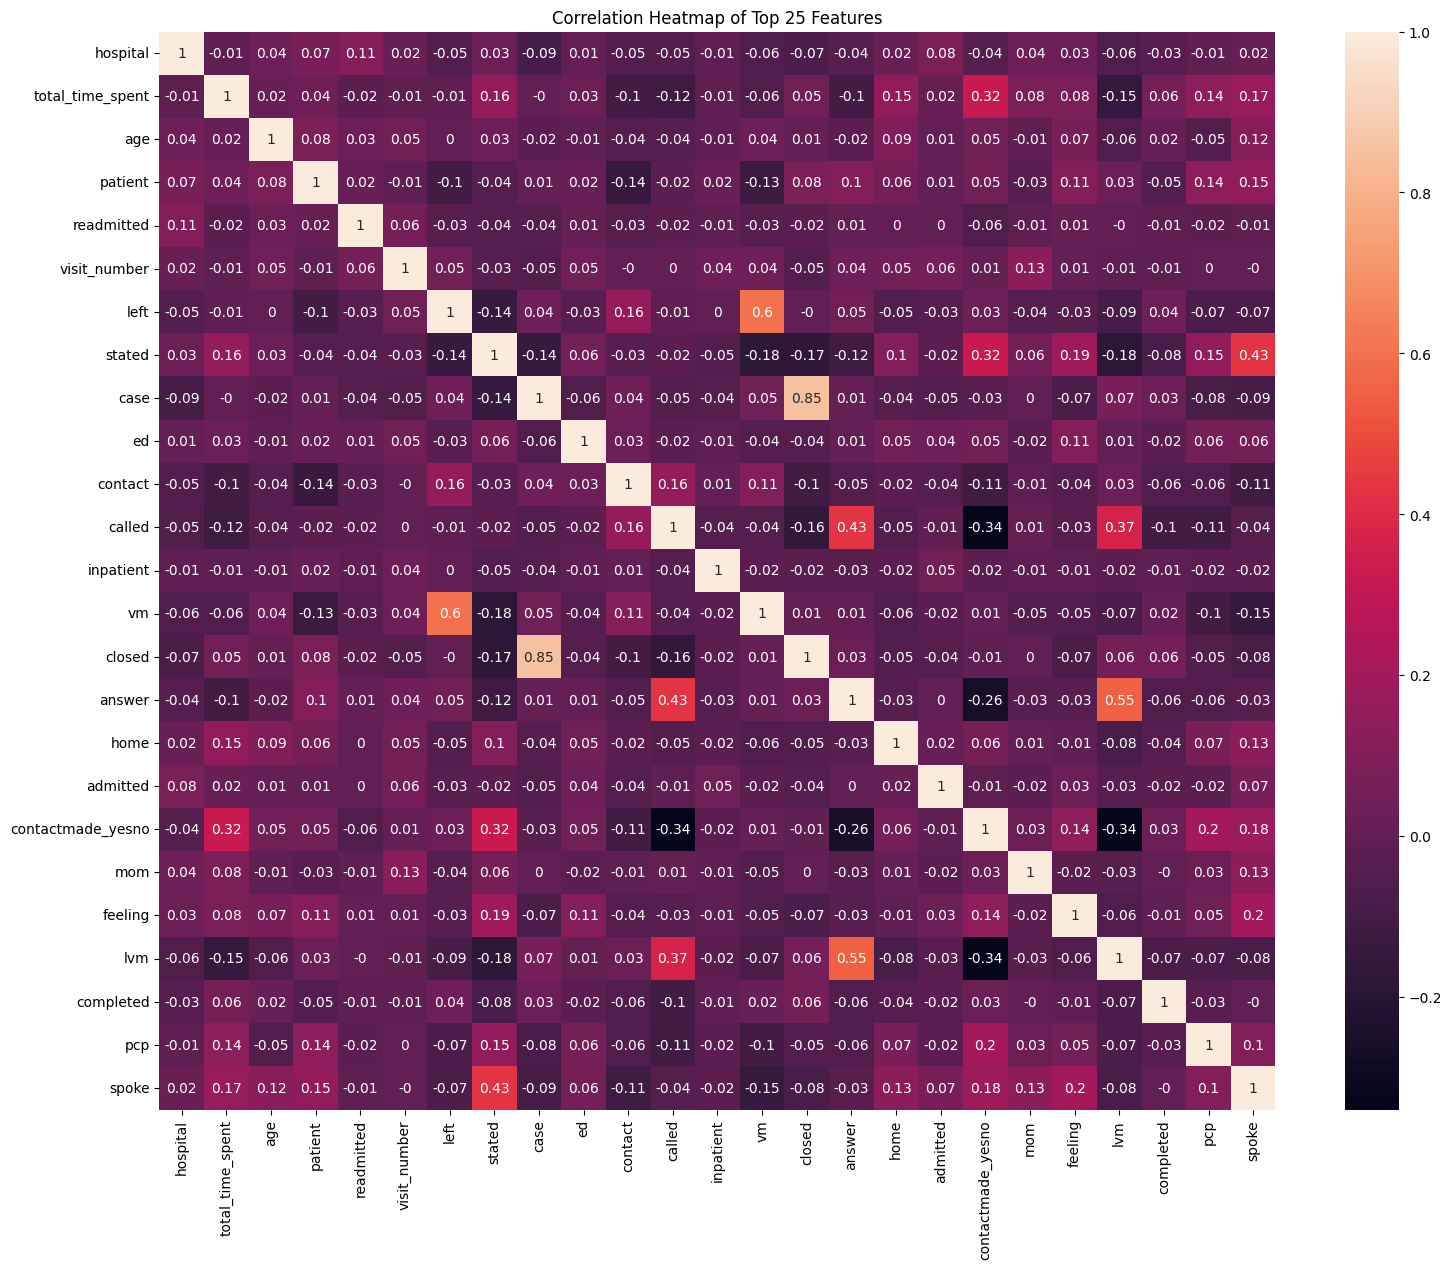

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
top_25_features = important_features[:25]
X_train_filtered_top_25 = X_train[top_25_features]
plt.figure(figsize=(18, 14))
sns.heatmap(X_train_filtered_top_25.corr().round(2),annot=True, )
plt.title('Correlation Heatmap of Top 25 Features')
plt.savefig('correlation_heatmap.png')
plt.show()

In [ ]:
suhi_df

,record_id,new_patient,visit_number,referral_date,day_readmit,age,sex_Male,Hispanic,AfricanAmerican,White,...,notes_contact4,notes_contact5,notes_contact6,notes_contact7,notes_contact8,notes_contact9,notes_contact10,additional_contact_notes,anything_else,combined_notes
0,2,0.0,1,2021-04-12,0.0,66,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
1,2,0.0,2,2021-05-26,NaN,66,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
2,4,1.0,1,2021-04-12,1.0,50,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Patient not available,declined
3,5,1.0,1,2021-04-12,0.0,61,1,0,1,0,...,CLOSED CASE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sdoh. emotional support. closed case
4,5,0.0,2,2021-09-23,0.0,59,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2608,2311,1.0,1,2024-02-12,NaN,60,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,i reached out to the pt but received no respon...
2609,2312,1.0,1,2024-02-12,NaN,35,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2/14/24 11:10am i called and spoke to pt. pt ...
2610,2313,1.0,1,2024-02-13,NaN,49,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
2611,2314,1.0,1,2024-02-13,NaN,62,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


In [ ]:
feature_importances = pd.read_excel('/content/feature_importances_patients_w_notes_preprocess.xlsx')

In [ ]:
for imp_feature in feature_importances[feature_importances['variable_type'] == 'text']['features'].values:
  print(100*'-')
  print(imp_feature)
  readmitted_patients = 0
  not_readmitted_patients = 0
  for note in suhi_df['combined_notes']:
    if imp_feature in note and suhi_df['day_readmit'].iloc[suhi_df['combined_notes'].tolist().index(note)] == 1:
      readmitted_patients += 1
    elif imp_feature in note and suhi_df['day_readmit'].iloc[suhi_df['combined_notes'].tolist().index(note)] == 0:
      not_readmitted_patients += 1
  print(f'Readmitted patients: {readmitted_patients}')
  print(f'Not readmitted patients: {not_readmitted_patients}')

----------------------------------------------------------------------------------------------------
hospital
Readmitted patients: 55
Not readmitted patients: 114
----------------------------------------------------------------------------------------------------
patient
Readmitted patients: 104
Not readmitted patients: 373
----------------------------------------------------------------------------------------------------
left
Readmitted patients: 47
Not readmitted patients: 216
----------------------------------------------------------------------------------------------------
readmitted
Readmitted patients: 19
Not readmitted patients: 5
----------------------------------------------------------------------------------------------------
lvm
Readmitted patients: 65
Not readmitted patients: 336
----------------------------------------------------------------------------------------------------
mom
Readmitted patients: 39
Not readmitted patients: 179
------------------------------------

In [ ]:
for imp_feature in feature_importances[feature_importances['variable_type'] == 'text']['features'].values[:2]:
  print(100*'-')
  print(imp_feature)
  for note in suhi_df['combined_notes']:
    if imp_feature in note:
      print(note)

----------------------------------------------------------------------------------------------------
hospital
looking for housing in the same and needs access to an elevator for her powered wheelchair.. the pt reached out to me to let me know she is currently back in the hospital. i reassured her that i'm looking for housing for her. i spoke with the pt about where the status of her  cha application.. closed case -
per meditech pt is still in the hospital. will monitor ehr daily. spoke with patient who stated he wants me to call him by his second name, jesse, he stated he is felling better. he stated that he was released form the hospital yesterday. he states has an appt to see a doctor thursday, he is not sure if this will be is pcp. pt stated he will talk to the doctor regarding his diabetes and high blood pressure. pt stated he will try to get medical insurance through his employer, pt stated he works as chef assistant and makes a decent income. pt agreed with me calling him back ne